In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fftshift, fft2, ifft2, ifftshift, fftfreq
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import matplotlib
from scripts.custom_functions import *
from matplotlib import rc
from matplotlib.backends.backend_pdf import PdfPages
import random
from tqdm import tqdm # has to be installed, otherwise just remove the tqdm range 

matplotlib.rcParams['font.size'] = 24
rc('font',**{'family':'fantasy','fantasy':['xkcd']})
rc('text', usetex=True)

# Parameters for the notebook
baseline = 257    # To get the right dataset, AR-AR if 257 or AR-GBT if 258
padding = True    # To use zero padding interpolation or not

if baseline == 258:
    data_real = np.fromfile('/mnt/scratch-lustre/simard/b0834/data/gb057_1.input_baseline258_freq_00_pol_all.rebint.1/weighted_average_0_1_6.bin', dtype=np.float32).reshape(660, 16384).T 
    data_imag = 1.0j * np.fromfile('/mnt/scratch-lustre/simard/b0834/data/gb057_1.input_baseline258_freq_00_pol_all.rebint.1/weighted_average_0_i_1_i_6_i.bin', dtype=np.float32).reshape(660, 16384).T 
    data = data_real + data_imag 
    bsl = 'AR-GBT'
elif baseline == 257:
    data = np.load('/mnt/scratch-lustre/bdesy/b0834/data/normalized_data/ds/257freq00.npy')
    bsl = 'AR-AR'

if padding:
    freq = (np.arange(data.shape[0]*2)*16./(data.shape[0]*2)+310.5-4) 
    time = np.arange(data.shape[1]*2)*6729.*2/(data.shape[1]*2) -6729/2
    doppler = (fftshift(fftfreq(data.shape[1]*2))*1./ np.diff(np.array(time)).mean())*1e3
    delay = (np.arange(data.shape[0]*2)-(data.shape[0]*2)/2)*1./(16.0e6)*1e3
    
else:
    freq = (np.arange(data.shape[0])*8./data.shape[0]+310.5) 
    time = np.arange(data.shape[1])*6729./data.shape[1]
    doppler = (fftshift(fftfreq(data.shape[1]))*1./ time[1])*1e3
    delay = (np.arange(data.shape[0])-data.shape[0]/2)*1./(8.0e6)*1e3
delayh = delay[len(delay)/2:]

# Defining extent of axes and plotting functions
extent_ds = [time[0], time[-1], freq[0], freq[-1]]
extent_no_pad = [time[len(time)/4], time[len(time)*3/4], freq[len(freq)/4], freq[len(freq)*3/4]]

def plot_ds(ds, start=0, end=-1, binning=(1,1), vmin=None, vmax=None, cmap=None, alttitle='', caract = '', output='show', extent=None):
    if binning != (1,1):
        pltds = binning(ds[start:end, :], binning[0], binning[1])
        caract += ' binned ' + str(binning)
    else:
        pltds = ds[start:end, :]
    if extent==None:
        extent=[time[0], time[-1], freq[start], freq[end]]
    fig = plt.figure(figsize=(11,9))
    plt.imshow(np.absolute(pltds), aspect='auto',
               origin="lower", 
               vmin=vmin, vmax=vmax, cmap=cmap,
               extent=extent)
    plt.colorbar()
    if alttitle=='':
        plt.title('Dynamic spectrum ' + bsl + ' from ' + str(round(freq[start])) + ' to ' \
                  + str(round(freq[end])) + ' MHz' + caract)
    else:
        plt.title(alttitle)
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [MHz]")
    if output == 'pdf':
        fig.savefig(pdf, format='pdf') 
        fig.clf()
        plt.close("all")
    elif output == 'show':
        plt.show()

def plot_ss(ss, start=(len(delay)-1)/2, end=len(delay)-1, binnin=(1,1), \
            vmin=None, vmax=None, cmap=None, alttitle='', mask=np.zeros((2,2)), alpha=0.9, output='show'):
    caract = ''

    if binnin != (1,1):
        pltss = binning(ss[start:end, :], binnin[0], binnin[1])
        caract += ' binned ' + str(binning)
    else:
        pltss = ss[start:end, :]
    fig = plt.figure(figsize=(11,9))
    plt.imshow(np.log10(np.absolute(pltss)+np.finfo(float).eps), aspect='auto',
               origin="lower", 
               vmin=vmin, vmax=vmax, cmap=cmap,
               extent=[doppler[0], doppler[-1], delay[start], delay[end]])
    plt.colorbar()
    
    if np.sum(mask)>0:
        mask = mask[start:end, :]
        plt.imshow((np.ma.masked_where(mask == 0, mask)), aspect='auto',
               origin="lower", cmap='winter', alpha=alpha, interpolation='spline16',
               extent=[doppler[0], doppler[-1], delay[start], delay[end]])
        
    if alttitle=='':
        plt.title('Secondary spectrum ' + bsl + ' from ' + str(round(delay[start], 2)) \
                  + ' to ' + str(round(delay[end], 2)) + ' MHz' + caract)
    else:
        plt.title(alttitle)

    plt.xlabel(r"Doppler shift $f_D$ [mHz]")
    plt.ylabel(r"Time delay $\tau$ [ms]")
    
    
    if output == 'pdf':
        fig.savefig(pdf, format='pdf') 
        fig.clf()
        plt.close("all")
    elif output == 'show':
        plt.show()

Handling of the gaps in the data to compute the mean properly, bars is for the 16 384x660 array and bars_pad is for the padded array, zeros at gaps and contour.

In [31]:
bars = ([np.abs(data - 0.0) < 1e-18 ][0]-1)*-1  # bars at 0, rest at 1, use plot_ds(bars) to see)
inv_bars = (bars-1)*-1                          # bars at 1, rest at 0
for i in range(bars.shape[1]):
    if np.sum(bars[:, i]) > 0:
        bars[:, i] = 1
coordo_bars = []
for i in range(bars.shape[1]-1):
    if (bars[100, i] == 0):
        if bars[100,i-1]==1:
            coordo_bars.append([i])
j=0
for i in range(bars.shape[1]-1):
    if (bars[100, i]== 1):
        if bars[100,i-1]==0:
            coordo_bars[j].append(i+1)
            j += 1
bars_pad = np.vstack((bars, np.zeros(bars.shape)))
bars_pad = np.hstack((bars_pad, np.zeros(bars_pad.shape)))
bars_pad = np.roll(np.roll(bars_pad, bars.shape[0]/2, axis=0), bars.shape[1]/2, axis=1)
inv_bars_pad = (bars_pad-1)*-1  

def remove_bars(data, coordo_bars):
    return np.hstack((data[:, :coordo_bars[0][0]], 
                      data[:, coordo_bars[0][1]:coordo_bars[1][0]], 
                      data[:, coordo_bars[1][1]:coordo_bars[2][0]], 
                      data[:, coordo_bars[2][1]:coordo_bars[3][0]], 
                      data[:, coordo_bars[3][1]:]))

data_no_bars = remove_bars(data, coordo_bars)
show=False
if show:
    plot_ds(data_no_bars, baseline, alttitle='Just to see, wrong axes')
    plot_ds(data, baseline, extent=extent_no_pad)
    plot_ds(bars, baseline, extent=extent_no_pad, alttitle='bars, a mask of zeros and ones')
    plot_ds(bars_pad, baseline, extent=extent_ds, alttitle='bars pad, a mask of zeros and ones')

We set the mean of the initial dynamic spectrum to 1, as well as the bars and contour if using padding. 

In [32]:
mean_data=np.mean(remove_bars(data, coordo_bars))
remove_bars(np.real(data)/mean_data, coordo_bars).mean()

1.0

1.00010542053


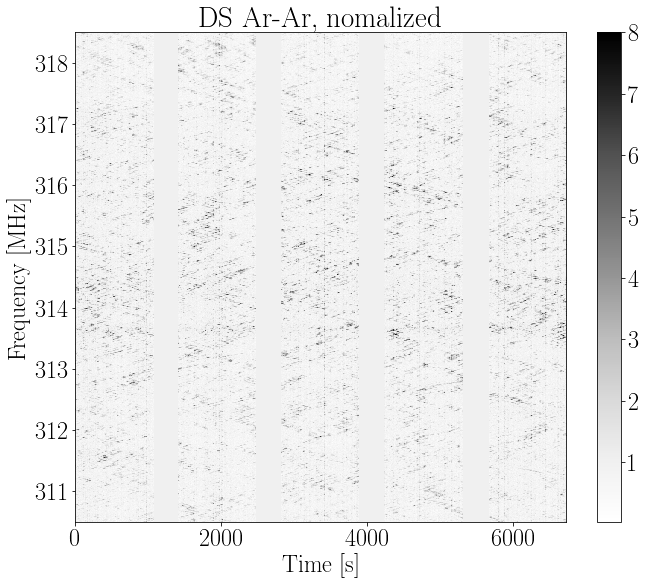

In [33]:
norm_data = (np.real(data)/mean_data)*(bars) + inv_bars
print(np.mean(norm_data))
plot_ds(norm_data, alttitle='DS Ar-Ar, nomalized', cmap='Greys', vmax=8, extent=extent_no_pad)

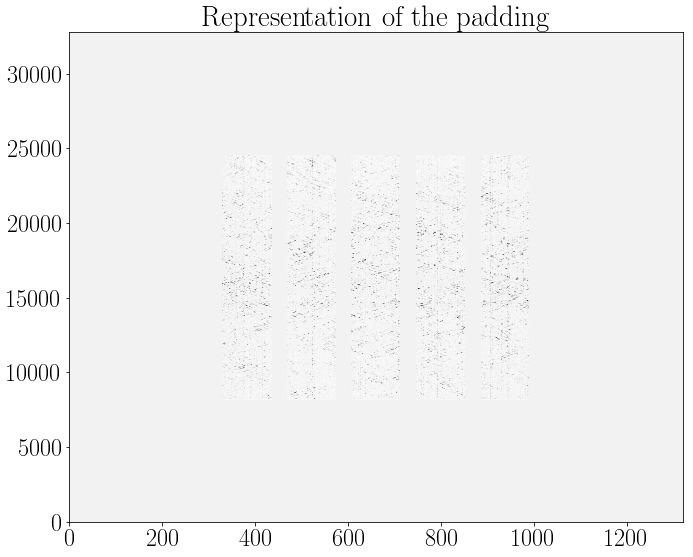

In [34]:
SS, ftI, I_pad = get_ss_cs(norm_data, baseline, padding=True, show=True)

We also create a conjugate spectrum with zeroed middle column and row

In [55]:
ftI_00ed = np.copy(ftI)
ftI_00ed[ftI_00ed.shape[0]/2,:]=0.
ftI_00ed[:, ftI_00ed.shape[1]/2]=0.

### Studying the deconvolved spectrum using the main arclet, it's dynamic spectrum and the correlation to the inital data.

Verification that FFTpack handles constants properly.

In [6]:
Conj_spec = fftshift(fft2(data)) 
DeconvolConj_spec = ifft2(ifftshift(Conj_spec))
show=False
if show :
    plot_ds(data, end=data.shape[0]/16, vmax=10)
    print(np.mean(DeconvolConj_spec))
    plot_ds(DeconvolConj_spec, end=data.shape[0]/16, vmax=10, caract='\n (FFT2 \& iFFT2)')
    print(np.mean(DeconvolConj_spec))
    plot_ds(np.round(DeconvolConj_spec-data, 6), alttitle='Substacted initial DS to deconvolved convolved DS')
    print(np.mean(DeconvolConj_spec-data))

Ok, now we know that the FFTpack routines don't do weird things to the data, let's start paying around with the main arclet spectrum!

In [36]:
main_apex = np.array([ -1.59000000e+01,   1.42545527e-01,   5.19540017e-03])
main_apex

array([ -1.59000000e+01,   1.42545527e-01,   5.19540017e-03])

Notes about Arclet object:
    
   - We don't directly used the ratios computed by the methods below, but it is useful to hide tau near the origin (see below)
   - Some of the methods needs a previous method to run (eg deconvolve and get_corr(elation) need the green from get_ds)
   - I don't think this class is optimal, so for development purposes I think it should stay in a Notebook. But to to put it in a module (example scripts.custom_functions) one could make it a subclass of a Data object so that it can acces to the SS, ftI, etc. without instanciating it for each individual arclet. 

In [77]:
class Arclet(object):
    def __init__(self, name, apex, hw, vw, rect=[0,0], a=None):
        '''
        params : 
        name (string) is only used when printing the object
        apex (list [doppler coordintate, delay coordinate, width]) 
             width used if instanciating arclets of different widths in a loop
        hv   (float) horizontal width in mHz, from the apex to one end of the arclet
        vw   (float) vertical width in ms at apex of arclet if using default aperture a 
             or all across the arclet if other aperture
        rect (list [width in mHz, height in ms]) a rectangle that hides the part of the mask near the origin
        a    (float) to precise parabola aperture for the arclet, 
             otherwise it defines upper and lower parabolas that aim at 0
        return :
        self.coordo =  [apex, hw, vw] to access after instanciation
        self.mask : mask covering the arclet, minimal infomation is the apex coordinates and width
                    for a mask that gets thinner, or if precised aperture constant thickness
        self.mask_00 : exact same mask centered at origin
        self.name used for priting the object
        '''
        self.coordo = [apex, hw, vw]
        self.mask = get_mask(doppler, delay, apex, fhw=hw, fvw=vw, rect=rect, a=a) #mask centered at apex
        self.name = name
        
        mask_flip = np.flipud(np.fliplr(self.mask))
        yroll = np.argmin(abs(delay-self.coordo[0][1]))-len(delay)/2 
        xroll = np.argmin(abs(doppler-self.coordo[0][0]))-len(doppler)/2 
        self.mask_00 = np.roll(np.roll(mask_flip,yroll+1,0), xroll+1,1)  # same mask centered at [0,0]
    
    def __repr__(self):
        '''print function for output of a print(Arclet object) command'''
        return self.name + ' Arclet object at ' + str(self.coordo[0][0]) + ' mHz f_D and ' + str(self.coordo[0][1]) + ' ms delay'
    
    # We define both ratios from conjugate spectrum and secondary spectrum, 
    #  they differs but see last section of notebook about how their difference is related to noise
    
    def get_ratio_cs(self):
        '''
        return :
        self.ratio_cs : square of magnification ratio from the conjugate spectrum
        self.flux_cs = flux of arclet on conjugate spectrum
        self.flux_ref_cs = flux of shape of arclet on main parabola of conjugate spectrum
        '''
        self.flux_cs = np.sum(np.absolute(ftI)*self.mask)
        self.flux_ref_cs = np.sum(np.absolute(ftI)*self.mask_00)
        self.ratio_cs = (self.flux_cs/self.flux_ref_cs)**2.
       
    def get_ratio_ss(self):
        '''
        return :
        self.ratio_ss : magnification ratio from the secondary spectrum
        self.flux_ss = flux of arclet on secondary spectrum
        self.flux_ref_ss = flux of shape of arclet on main parabola of secondary spectrum
        '''
        self.flux_ss = np.sum(np.absolute(SS)*self.mask)
        self.flux_ref_ss = np.sum(np.absolute(SS)*self.mask_00)
        self.ratio_ss = (self.flux_ss/self.flux_ref_ss)
    
    def get_ds(self):
        '''
        return : 
        self.cs_apex : conjugate spectrum of arclet only, at position of apex
        self.cs_origin : conjugate spectrum of arclet only, rolled to the origin
        self.green : iFFT of cs_origin
        self.ds : square modulus of green
        '''
        self.cs_apex = ftI*self.mask                # to plot it and double-checking
        yroll = -np.argmin(abs(delay-self.coordo[0][1]))-len(delay)/2 
        xroll = -np.argmin(abs(doppler-self.coordo[0][0]))-len(doppler)/2 
        self.cs_origin = np.roll(np.roll(self.cs_apex, yroll, 0), xroll, 1)  # to plot it and double-checking
        self.green = ifft2(ifftshift(self.cs_origin))
        self.ds = np.absolute(self.green*np.conjugate(self.green))    # np.absolute just to remove the 0j term
        
    def deconvolve(self):
        '''
        return :
        self.I : dynamic spectrum obtained from iFFT the conjugate spectrum 
                    with the middle row and column set to 0
        self.deconvolved_ds : I * e^(-i *phases of green)
        self.deconvolution : FFT of deconvolved_ds (no resetting of gaps and contour to 0)
        '''
        self.I = ifft2(ifftshift(ftI_00ed))
        self.deconvolved_ds = np.absolute(self.I)*np.exp(-1.0j*np.angle(self.green))
        self.deconvolution = fftshift(fft2(self.deconvolved_ds))
    
    def get_corr_ds(self, to='ds'):
        ''' 
        here we can correlate two things, either the dynamic spectrum or the green functione,
        use the tag to= to select. This outputs both correlation to initial data (self.corr_data) 
        and to the inverse FFT of the conjugate spectrum with zeroed power at middle rows and colums (self.corr_conj) 
        '''
        x = ifft2(ifftshift(ftI_00ed))
        if to == 'green':
            y = self.green
        elif to == 'ds':
            y = self.ds
        self.corr_conj = np.sum(  np.absolute(x-np.mean(x)) * np.absolute(y-np.mean(y))  ) \
                                /(np.sqrt(  np.sum(np.absolute(x-np.mean(x))**2)*np.sum(np.absolute(y-np.mean(y))**2))  )
        x = ifft2(ifftshift(ftI))
        self.corr_data = np.sum(  np.absolute(x-np.mean(x)) * np.absolute(y-np.mean(y))  ) \
                                /(np.sqrt(  np.sum(np.absolute(x-np.mean(x))**2)*np.sum(np.absolute(y-np.mean(y))**2))  )

In [78]:
ma = Arclet('main', main_apex, 12.0, 0.008)
ma.get_ds()
ma.get_ratio_cs()
ma.get_ratio_ss()

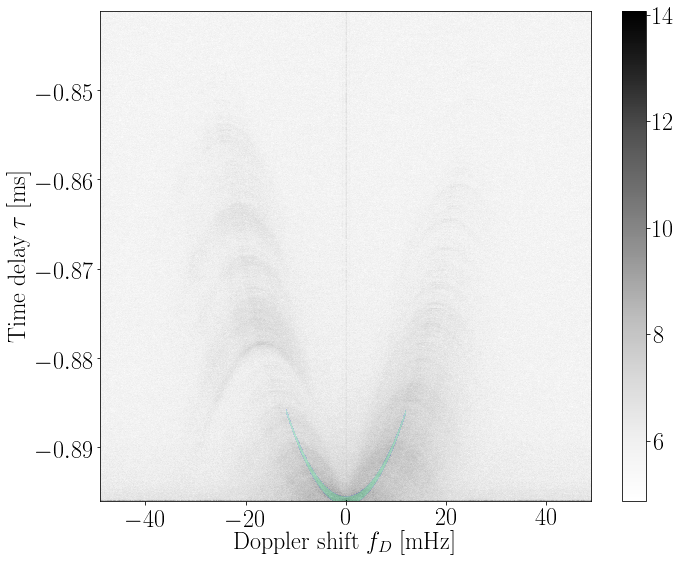

In [79]:
pltss=binning(SS, 2, 8) 
# can also try mask=ma.mask_00 to see the mask at the origin used to compute ratios
plot_ss(pltss, cmap='Greys',  mask=binning(ma.mask_00, 2, 8), alpha=0.2, start=pltss.shape[0]/2, end=pltss.shape[0]*5/7, alttitle=' ')

In [80]:
ma.deconvolve()

In [72]:
np.mean(I_pad)

1.0001054205261179

The deconvolve method doesn't automatically reset the gaps and contour of the array to the mean, as we can see above. To see the difference, we can do it ourselves.

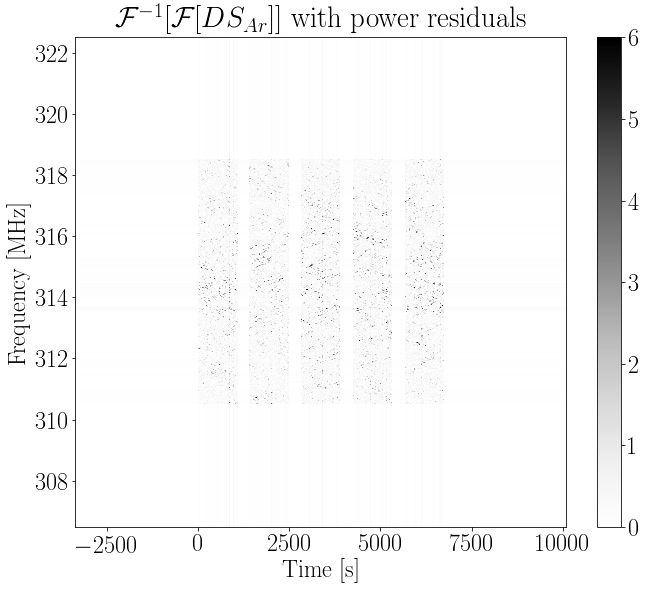

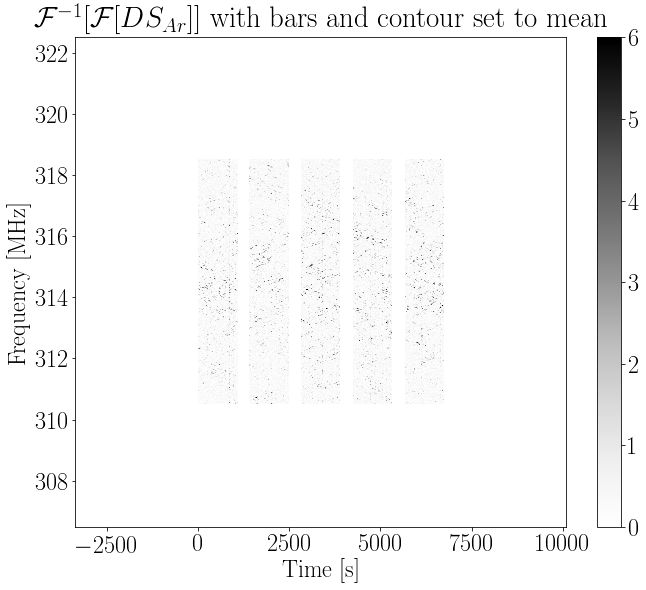

In [81]:
# To see the look of the amplitudes used for the deconvolution if not reset to the mean

plot_ds(ma.I, alttitle=r'$\mathcal{F}^{-1}[\mathcal{F}[DS_{Ar}]]$ with power residuals', cmap='Greys', vmax=6)
plot_ds(ma.I*bars_pad + inv_bars_pad*np.mean(ma.I), alttitle=r'$\mathcal{F}^{-1}[\mathcal{F}[DS_{Ar}]]$ with bars and contour set to mean', cmap='Greys', vmax=6)

In [82]:
# version of deconvolution with contour and gaps set back to mean
amplitude = ma.I*bars_pad + inv_bars_pad*np.mean(ma.I)
madeconvolution = fftshift(fft2(amplitude*np.exp(-1.0j*np.angle(ma.green))))

In [42]:
bmad=binning(madeconvolution, 2, 8)

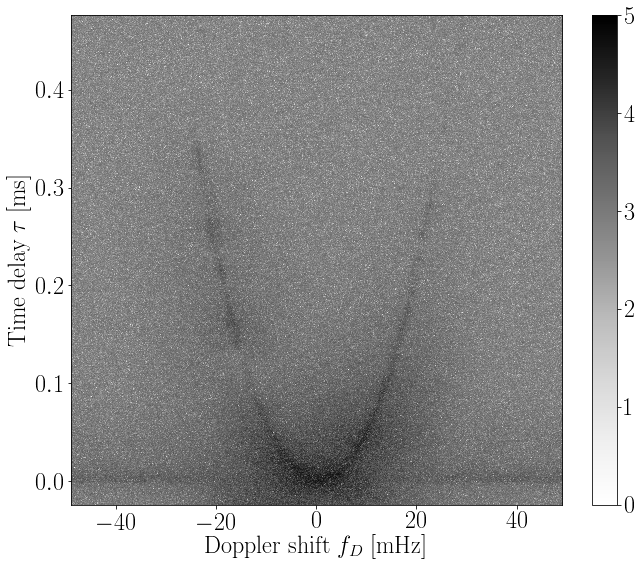

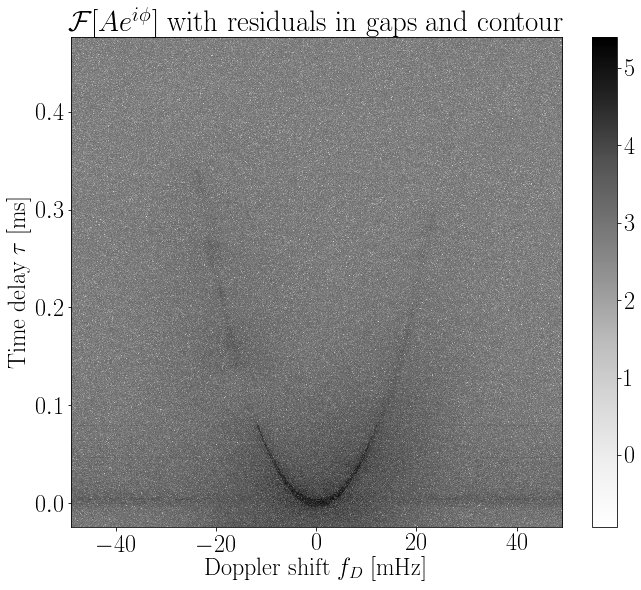

In [84]:
#plot_ds(ma.I, cmap='Greys', alttitle='Amplitude A containing residuals in DS caused by \n zeroing the middle rows and cols of conjugate spectrum')
#plot_ds(np.angle(ma.green), cmap='Greys', alttitle=r'Phases $\phi$ of Green function of main arclet')
#plot_ds(np.real(ma.deconvolved_ds*bars_pad), alttitle='$\Re [ Ae^{i\phi} ] $ bars and contour set at 0', cmap='Greys')
#plot_ds(np.imag(ma.deconvolved_ds)*bars_pad, alttitle='$\Im [ Ae^{i\phi} ]$ bars and contour set at 0 ', cmap='Greys')
plot_ss(madeconvolution, cmap='Greys', start=16000, vmin=0, vmax=5, end=24000, alttitle=' ')#'$\mathcal{F}[ Ae^{i\phi} ]$, residuals in gaps and contour set at 0')
plot_ss(ma.deconvolution, cmap='Greys', start=16000, end=24000, alttitle='$\mathcal{F}[ Ae^{i\phi} ]$ with residuals in gaps and contour')

To compute the mean of the dynamic spectrum of the arclet, we need to remove the contour and the gaps in the data. We bouble check that the dynamic spectrum used to cut out the arclet was indeed set to mean=1

In [85]:
mean_region = ma.ds[ma.ds.shape[0]/4:ma.ds.shape[0]*3/4, ma.ds.shape[1]/4:ma.ds.shape[1]*3/4] # take only the middle
mean_reg = remove_bars(mean_region, coordo_bars) # remove the bars
mean_mads = mean_reg.mean()

mean_regionDS = I_pad[I_pad.shape[0]/4:I_pad.shape[0]*3/4, I_pad.shape[1]/4:I_pad.shape[1]*3/4]  # take only the middle
mean_regDS = remove_bars(mean_regionDS, coordo_bars) # remove the bars
mean_DS = mean_regDS.mean()

print('Mean of DS without the contour and bars = {0}\nMean of initial CS from which the arclet has been cutted out = {1}'.format(mean_mads, mean_DS))

Mean of DS without the contour and bars = 0.000654934216994
Mean of initial CS from which the arclet has been cutted out = 1.0


We see that the mean of the DS is still 2 orders of magnitude lower that the magnification computed with the masks method (see hiding tau below).




Normalized representation of DS of arclet to compare with initial data with same color bar.

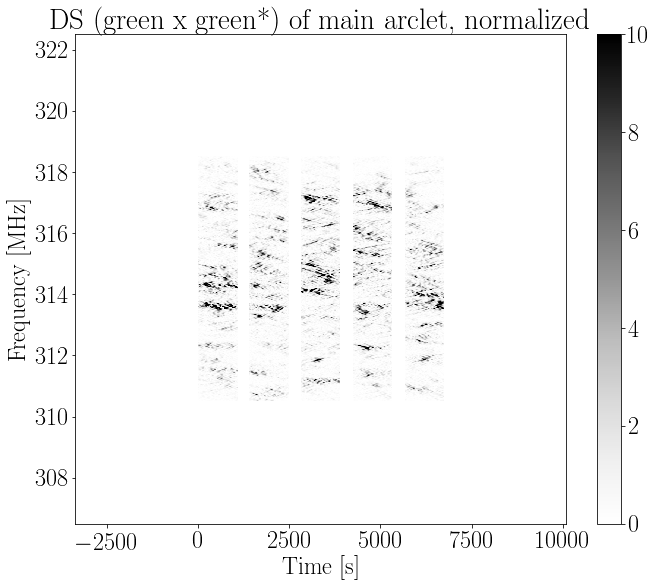

In [86]:
arclet_ds_pad_norm = (ma.ds/(mean_mads))*bars_pad
plot_ds(arclet_ds_pad_norm, 
        alttitle='DS (green x green*) of main arclet, normalized', 
        cmap='Greys', vmax=10, 
        extent = [time[0], time[-1], freq[0], freq[-1]])

### See evolution of ratios as we mask more and more $\tau$ from the main arclet of shape 12 x 0.008

Routine to compute a ratio curve against how much tau is hidden.

In [87]:
taus = np.arange(85*2)*1./2000

In [88]:
ratios_ss = []
ratios_cs = []
for i in tqdm(range(len(taus))):
    tau = taus[i]
    arc = Arclet(str(i), main_apex, hw=12.0, vw=0.008, rect=[25., tau])
    arc.get_ratio_ss()
    arc.get_ratio_cs()
    ratios_ss.append(arc.ratio_ss)
    ratios_cs.append(arc.ratio_cs)

100%|██████████| 170/170 [12:10<00:00,  4.29s/it]


As we can see below, the difference between ratios computed with CS and SS is highest where the noise contributes the most (near no tau hidden, 0 on x axis, and where we almost hide all of the arclet, over 0.45 on x axis). This suggest that the difference is mainly due to squaring random noise when computing the SS. The difference is included in the error bars.

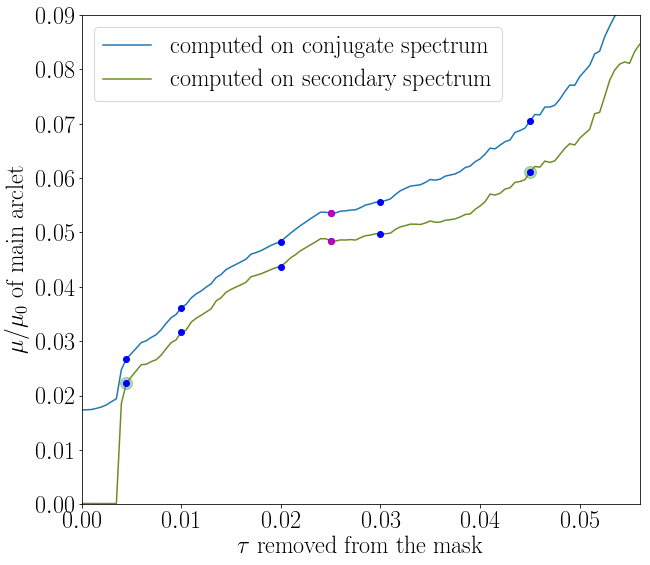

In [89]:
indices = [9, 20, 40, 50, 60, 90]
fig = plt.figure(figsize=(10, 9))
plt.plot(taus, ratios_cs, label='computed on conjugate spectrum')
plt.plot(taus[90], ratios_ss[90], 'go', ms=12, alpha=0.3)
plt.plot(taus[9], ratios_ss[9], 'go', ms=12, alpha=0.3)
for i in indices:
    plt.plot(taus[i], ratios_cs[i], 'bo')
plt.plot(taus[50], ratios_cs[50], 'mo')
plt.plot(taus, ratios_ss, color='olivedrab', label='computed on secondary spectrum')
for i in indices:
    plt.plot(taus[i], ratios_ss[i], 'bo')
plt.plot(taus[50], ratios_ss[50], 'mo')
plt.ylabel(r'$\mu/\mu_0$ of main arclet')
plt.xlabel(r'$\tau$ removed from the mask')
plt.ylim(0., 0.09)
plt.xlim(0., 0.056)
plt.title(' ')
plt.legend()
plt.show()

In [90]:
taus[50]

0.025000000000000001

The ratio that makes the most sense would be where the curve is nearly flat at 0.025 hidden $\tau$. One way to compute de error bars would be the standard deviation before the curve starts to deviate, that is to say between the first blue point and the fifth (big green dot). We don't account for no tau hidden because it includes numerical infinities near the origin.

In [91]:
print('best ratio cs: ' + str(ratios_cs[50]) + ' more of less ' + str(np.std(np.array(ratios_cs[9:90]))))
print('best ratio ss: ' + str(ratios_ss[50]) + ' more of less ' + str(np.std(np.array(ratios_ss[9:90]))))

best ratio cs: 0.0535311782614 more of less 0.0112010239247
best ratio ss: 0.0484720081582 more of less 0.00979703341827


We select the ratio computed with the secondary spectrum since it is coherent with the flux curve methods for the faint arclets but the error bar widely covers the value computed with the conjugate spectrum.  

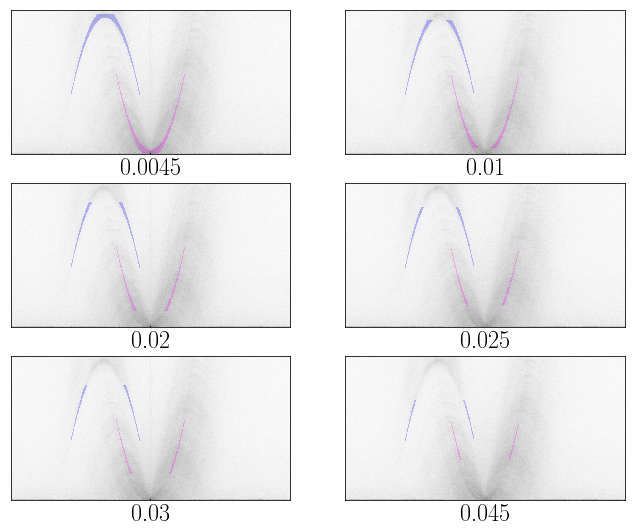

In [92]:
arclets = [Arclet(str(i), main_apex, 12.0, 0.008, rect=[25., taus[i]]) for i in indices]
fig = plt.figure(figsize=(11,9))
ax1, ax2, ax3, ax4, ax5, ax6 = fig.add_subplot(321), fig.add_subplot(322), fig.add_subplot(323), fig.add_subplot(324), fig.add_subplot(325), fig.add_subplot(326)
extent = [doppler[0], doppler[-1], delay[(len(delay)-1)/2], delay[len(delay)*4/7]]
alpha=0.4
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
pltss=binning(SS, 2, 16)
for i in range(6):
    axes[i].imshow(np.log10(np.absolute(pltss))[pltss.shape[0]/2:pltss.shape[0]*4/7, :],
             cmap='Greys', aspect='auto', origin='lower', extent=extent)
    axes[i].imshow(np.ma.masked_where(arclets[i].mask_00 == 0, arclets[i].mask_00)[(len(delay)-1)/2:len(delay)*4/7, :], 
             cmap='spring', aspect='auto', origin='lower', extent=extent, alpha=0.25)
    axes[i].imshow(np.ma.masked_where(arclets[i].mask == 0, arclets[i].mask)[(len(delay)-1)/2:len(delay)*4/7, :], 
             cmap='winter', aspect='auto', origin='lower', extent=extent, alpha=0.25)
    axes[i].set_xlabel(str(taus[indices[i]]))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()